In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
train_df = pd.read_csv('./data/application_train.csv.zip')
train_df = train_df.rename(lambda x: x.lower(), axis=1)
train_df.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
test_df = pd.read_csv('./data/application_test.csv.zip')
test_df = test_df.rename(lambda x: x.lower(), axis=1)
test_df.head()

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Columns

In [4]:
target_column = 'target'

id_column = 'sk_id_curr'

# numeric columns
child_cnt_column = 'cnt_children'
amt_columns = ['amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price']
reg_pop_column = 'region_population_relative'
days_columns = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish']
car_age_column = 'own_car_age'

# categorical columns
contract_column = 'name_contract_type'
gender_column = 'code_gender'
flag_own_columns = ['flag_own_car', 'flag_own_realty']
name_columns = ['name_type_suite', 'name_income_type', 'name_education_type', 
                'name_family_status', 'name_housing_type']
flag_columns = ['flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile',
                'flag_phone', 'flag_email']

In [5]:
X_train = train_df.drop([target_column], axis=1)
y_train = train_df[target_column].copy()
X_train.shape, y_train.shape

((307511, 121), (307511,))

In [6]:
y_train_count = train_df[target_column].value_counts()[1]
y_train_count

24825

### Stratified sampling

In [7]:
def get_equal_classes(df, target_column, sample_size, random_state):
    sample_df = (train_df.groupby(target_column, as_index=False)
                         .apply(lambda x: x.sample(sample_size, random_state=random_state))
                         .sample(frac=1))
    return sample_df

In [8]:
sample_size = 1000
random_state = 42

sample_df = get_equal_classes(train_df, target_column, sample_size, random_state)
sample_df.groupby(target_column)[target_column].count()

target
0    1000
1    1000
Name: target, dtype: int64

### Pipeline

In [9]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [10]:
from scipy.stats import randint as sp_randint

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, CategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cross_validation import cross_val_score

from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline as imbp

from xgboost import XGBClassifier


/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [12]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, label=None):
        self.label = label
    
    def fit(self, X, y=None):
        if self.label:
            self.fill_values_ = self.label 
        else:
            self.fill_values_ = X.mode().iloc[0]
        return self
    
    def transform(self, X):
        return X.fillna(self.fill_values_).values

In [13]:
num_columns = [child_cnt_column] + amt_columns + [reg_pop_column] + days_columns + [car_age_column]
num_columns

['cnt_children',
 'amt_income_total',
 'amt_credit',
 'amt_annuity',
 'amt_goods_price',
 'region_population_relative',
 'days_birth',
 'days_employed',
 'days_registration',
 'days_id_publish',
 'own_car_age']

In [14]:
cat_columns = [contract_column] + [gender_column] + flag_own_columns + name_columns + flag_columns
cat_columns

['name_contract_type',
 'code_gender',
 'flag_own_car',
 'flag_own_realty',
 'name_type_suite',
 'name_income_type',
 'name_education_type',
 'name_family_status',
 'name_housing_type',
 'flag_mobil',
 'flag_emp_phone',
 'flag_work_phone',
 'flag_cont_mobile',
 'flag_phone',
 'flag_email']

In [15]:
sample_sizes = {0: sample_size, 1: sample_size}
pipeline = imbp.Pipeline([
    ('features', FeatureUnion([
        ('numeric', Pipeline([
            ('extract', ColumnExtractor(columns=num_columns)),
            ('impute', SimpleImputer(strategy='mean')),
            ('normalize', StandardScaler()),
            #('bin', NumericBinner(bins=4)),
            #('to_ordered_cat', CategoricalEncoder(encoding='ordinal'))
        ])),
        ('categorical', Pipeline([
            ('extract', ColumnExtractor(columns=cat_columns)),
            ('impute', CategoricalImputer()),
            ('encoding', CategoricalEncoder('onehot-dense', handle_unknown='ignore'))
        ]))
    ])),
    ('pca', PCA(n_components=0.99)),
    ('sampling', RandomUnderSampler(ratio=sample_sizes, random_state=random_state)),
    ('clf', LogisticRegression())
])

In [16]:
transform_pipeline = imbp.Pipeline([
    ('features', FeatureUnion([
        ('numeric', Pipeline([
            ('extract', ColumnExtractor(columns=num_columns)),
            ('impute', SimpleImputer(strategy='mean')),
            ('normalize', StandardScaler()),
            #('bin', NumericBinner(bins=4)),
            #('to_ordered_cat', CategoricalEncoder(encoding='ordinal'))
        ])),
        ('categorical', Pipeline([
            ('extract', ColumnExtractor(columns=cat_columns)),
            ('impute', CategoricalImputer()),
            ('encoding', CategoricalEncoder('onehot-dense', handle_unknown='ignore'))
        ]))
    ])),
    ('pca', PCA(n_components=0.99)),
    ('sampling', RandomUnderSampler(ratio=sample_sizes, random_state=random_state))
])

In [17]:
X_train_sample, y_train_sample = transform_pipeline.fit_sample(X_train, y_train)
X_train_sample.shape, y_train_sample.shape

((2000, 28), (2000,))

In [19]:
param_dist_grid = [
                       {'clf': [LogisticRegression()],
                        'clf__random_state': [random_state],
                        'clf__penalty': ['l1', 'l2'], 
                        'clf__C': np.logspace(-3, 3, num=7),
                        'clf__max_iter': [1000]},
#                        {'clf': [GaussianNB()],
#                         'clf__var_smoothing': np.logspace(-11, -7, num=5)},
#                        {'clf': [KNeighborsClassifier()],
#                         'clf__n_neighbors': [300, 400, 500],
#                         'clf__weights': ['uniform', 'distance']},
#                        {'clf': [DecisionTreeClassifier()],
#                         'clf__random_state': [random_state],
#                         'clf__max_depth': [5, 10, 15, 20],
#                         'clf__min_samples_split': sp_randint(2, 11),
#                         'clf__min_samples_leaf': sp_randint(1, 11),
#                         'clf__criterion': ['gini', 'entropy']},
                       {'clf': [RandomForestClassifier()],
                        'clf__random_state': [random_state],
                        'clf__max_depth': [3, 5, 7],
                        'clf__n_estimators': [500, 700, 900],
                        'clf__min_samples_split': sp_randint(2, 50),
                        'clf__min_samples_leaf': sp_randint(1, 50),
                        'clf__criterion': ['gini', 'entropy'],
                        'clf__class_weight': [None, 'balanced', 'balanced_subsample']},
#                        {'clf': [ExtraTreesClassifier()],
#                         'clf__random_state': [random_state],
#                         'clf__max_depth': [3, 5, 7],
#                         'clf__n_estimators': [500, 700, 1000],
#                         'clf__min_samples_split': sp_randint(2, 50),
#                         'clf__min_samples_leaf': sp_randint(1, 50),
#                         'clf__criterion': ['gini', 'entropy'],
#                         'clf__class_weight': [None, 'balanced', 'balanced_subsample']},
#                        {'clf': [LinearSVC()],
#                         'clf__random_state': [random_state],
#                         'clf__penalty': ['l2'],
#                         'clf__dual': [False],
#                         'clf__C': np.logspace(-2, 2, 5),
#                         'clf__max_iter': [100]},
                       {'clf': [SVC()],
                        'clf__random_state': [random_state],
                        'clf__kernel': ['linear', 'rbf', 'sigmoid'],
                        'clf__C': np.logspace(-2, 2, 5),
                        'clf__gamma': ['auto', 'scale'],
                        'clf__class_weight': [None, 'balanced'],
                        'clf__probability': [True]},
#                        {'clf': [SVC()],
#                         'clf__random_state': [random_state],
#                         'clf__kernel': ['poly'],
#                         'clf__degree': [3, 4, 5],
#                         'clf__C': np.logspace(-2, 2, 5),
#                         'clf__gamma': ['auto', 'scale'],
#                         'clf__class_weight': [None, 'balanced'],
#                         'clf__probability': [True]},
#                        {'clf': [QuadraticDiscriminantAnalysis()],
#                         'clf__reg_param': [0, 0.05, 0.1, 0.15, 0.2]},
#                        {'clf': [LinearDiscriminantAnalysis()]},
#                        {'clf': [MLPClassifier()],
#                         'clf__random_state': [random_state],
#                         'clf__alpha': np.logspace(-5, 3, num=9),
#                         'clf__learning_rate': ['constant', 'invscaling', 'adaptive'],
#                         'clf__max_iter': [1000]}
                  ]

n_iter_search = 5
classifiers = []

for (i, param_dist) in enumerate(param_dist_grid):
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, scoring='roc_auc', cv=3, 
                                       n_jobs=-1, n_iter=n_iter_search, random_state=random_state, 
                                       verbose=1, iid=True, return_train_score=True)
    random_search.fit(X_train, y_train)
    
    clf_name = str(i)
    clf_estimator = random_search.best_estimator_
    classifiers.append((clf_name, clf_estimator))
    
    print('Best Params:')
    print(random_search.best_params_)
    print('Train Score: {0:.5f} +- {1:.5f}'.format(random_search.cv_results_['mean_train_score'][0],
                                         random_search.cv_results_['std_train_score'][0]))
    print('Test Score: {0:.5f} +- {1:.5f}'.format(random_search.cv_results_['mean_test_score'][0],
                                        random_search.cv_results_['std_test_score'][0]))
    print()

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.0min finished


Best Params:
{'clf__random_state': 42, 'clf__penalty': 'l2', 'clf__max_iter': 1000, 'clf__C': 0.10000000000000001, 'clf': LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)}
Train Score: 0.63862 +- 0.00477
Test Score: 0.63870 +- 0.00239

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.4min finished


Best Params:
{'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=24,
            min_weight_fraction_leaf=0.0, n_estimators=900, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False), 'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 19, 'clf__min_samples_split': 24, 'clf__n_estimators': 900, 'clf__random_state': 42}
Train Score: 0.63800 +- 0.00361
Test Score: 0.63525 +- 0.00373

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.0min finished


Best Params:
{'clf__random_state': 42, 'clf__probability': True, 'clf__kernel': 'linear', 'clf__gamma': 'auto', 'clf__class_weight': None, 'clf__C': 0.01, 'clf': SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)}
Train Score: 0.63854 +- 0.00420
Test Score: 0.63872 +- 0.00276



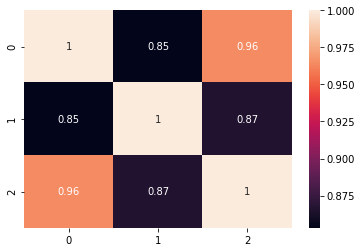

In [20]:
preds = np.hstack(clf[1].predict_proba(test_df)[:, 1].reshape(-1, 1) for clf in classifiers)
preds_df = DataFrame(preds)
sns.heatmap(preds_df.corr(), annot=True)

In [21]:
voting_pipe = Pipeline([
    ('voting', VotingClassifier(classifiers, voting='soft'))
])

In [22]:
cross_val_score(voting_pipe, X_train, y_train, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] .......................................................  -  55.9s
[CV] .......................................................  -  55.6s
[CV] .......................................................  -  55.5s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   57.9s finished


array([ 0.64105563,  0.64666652,  0.6411037 ])

In [23]:
from itertools import product

def get_bin_combinations(classifiers_num):
    return list(product(range(2), repeat=classifiers_num))[1:]

In [24]:
param_grid = {'voting__weights': get_bin_combinations(len(classifiers))}
param_grid['voting__weights'][:10]

[(0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]

In [25]:
grid_search = GridSearchCV(voting_pipe, param_grid=param_grid, n_jobs=-1, scoring='roc_auc', cv=2,
                           verbose=2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[CV] voting__weights=(0, 0, 1) .......................................
[CV] voting__weights=(0, 0, 1) .......................................
[CV] voting__weights=(0, 1, 0) .......................................
[CV] voting__weights=(0, 1, 0) .......................................
[CV] ........................ voting__weights=(0, 0, 1), total= 1.4min
[CV] voting__weights=(0, 1, 1) .......................................
[CV] ........................ voting__weights=(0, 1, 0), total= 1.4min
[CV] ........................ voting__weights=(0, 0, 1), total= 1.4min
[CV] voting__weights=(0, 1, 1) .......................................
[CV] voting__weights=(1, 0, 0) .......................................
[CV] ........................ voting__weights=(0, 1, 0), total= 1.4min
[CV] voting__weights=(1, 0, 0) .......................................
[CV] ........................ voting__weights=(0, 1, 1), total= 1.4min
[CV] voting__weig

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.8min finished
/home/dlabazkin/miniconda3/envs/otus/lib/python3.6/site-packages/sklearn/model_selection/_search.py:734: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('voting', VotingClassifier(estimators=[('0', Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(columns=['cnt_children', 'amt_income_total', 'amt_credit', 'amt_annuity', 'amt....001, verbose=False))]))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'voting__weights': [(0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [26]:
cv_results=grid_search.cv_results_
for params, mean_score in zip(cv_results["params"], cv_results["mean_test_score"]):
    print(params, mean_score)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

{'voting__weights': (0, 0, 1)} 0.639126316681
{'voting__weights': (0, 1, 0)} 0.635338081786
{'voting__weights': (0, 1, 1)} 0.641404298163
{'voting__weights': (1, 0, 0)} 0.640253240748
{'voting__weights': (1, 0, 1)} 0.640535816834
{'voting__weights': (1, 1, 0)} 0.642603407126
{'voting__weights': (1, 1, 1)} 0.6422784322
Best score: 0.6426034071264077
Best parameters set:
	voting__weights: (1, 1, 0)


### Predict on testing dataset by best model

In [39]:
test_df.shape

(48744, 121)

In [40]:
test_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
sk_id_curr                      int64
name_contract_type              object
code_gender                     object
flag_own_car                    object
flag_own_realty                 object
cnt_children                    int64
amt_income_total                float64
amt_credit                      float64
amt_annuity                     float64
amt_goods_price                 float64
name_type_suite                 object
name_income_type                object
name_education_type             object
name_family_status              object
name_housing_type               object
region_population_relative      float64
days_birth                      int64
days_employed                   int64
days_registration               float64
days_id_publish                 int64
own_car_age                     float64
flag_mobil                      int64
flag_emp_phone                 

In [47]:
best_estimator = grid_search.best_estimator_
best_model = best_estimator.fit(X_train, y_train)
y_pred = best_model.predict_proba(test_df)
y_pred.shape

(48744, 2)

In [48]:
y_pred[:10, 1]

array([ 0.42711473,  0.61193677,  0.39186981,  0.34814794,  0.60948803,
        0.31458366,  0.43074024,  0.58842591,  0.41735418,  0.43823343])

### Save predictions to file

In [49]:
submission_file = './submissions/submission.csv'

In [50]:
result_df = DataFrame({'SK_ID_CURR': test_df['sk_id_curr'],
                       'TARGET': y_pred[:, 1]})
result_df.head()

,SK_ID_CURR,TARGET
0,100001,0.427115
1,100005,0.611937
2,100013,0.391870
3,100028,0.348148
4,100038,0.609488


In [51]:
result_df.to_csv(submission_file, index=False)
!head {submission_file}

SK_ID_CURR,TARGET
100001,0.4271147280618766
100005,0.6119367668649773
100013,0.39186980847233704
100028,0.3481479433124779
100038,0.6094880337958517
100042,0.31458366447785097
100057,0.4307402447451705
100065,0.5884259122975064
100066,0.4173541787330521


### Submit to Kaggle

In [52]:
!kaggle competitions submit -c home-credit-default-risk -f {submission_file} -m " "

Successfully submitted to Home Credit Default Risk

In [53]:
!kaggle competitions submissions -c home-credit-default-risk

fileName        date                 description  status    publicScore  privateScore  
--------------  -------------------  -----------  --------  -----------  ------------  
submission.csv  2018-06-03 12:31:14               complete  0.638        None          
submission.csv  2018-06-02 22:57:59               complete  0.650        None          
submission.csv  2018-06-02 10:05:31               complete  0.690        None          
submission.csv  2018-06-01 14:10:18               complete  0.673        None          
submission.csv  2018-06-01 13:44:23               complete  0.648        None          
submission.csv  2018-05-31 12:17:41               complete  0.663        None          
submission.csv  2018-05-31 09:39:38  Baseline     complete  0.639        None          
submission.csv  2018-05-31 09:38:44  Baseline     error     None         None          
